In [1]:
using JuMP, NamedArrays, PyPlot

In [2]:
WIDTH = 51 # odd number
HEIGHT = 41 # odd number
NRG = min(WIDTH, HEIGHT)

type Request
    pickup_pos::Tuple{Int64, Int64}
    pickup_time::Int
    dropoff_pos::Tuple{Int64, Int64}
    duration::Int
end

type Depot
    cur_pos::Tuple{Int64, Int64}
end

In [3]:
function manhattan_distance(a, b)
    return sum(abs.([i for i in a]-[i for i in b]))
end

function rand_xy()
   return (rand(1:WIDTH), rand(1:HEIGHT)) 
end


function rand_uniform_xy()
    pass_x = Int(round((randn()/6+0.5)*(NRG-1)+1))
    pass_y = Int(round((randn()/6+0.5)*(NRG-1)+1))
    if WIDTH > HEIGHT
        pass_x += Int(round((WIDTH-HEIGHT)/2))
    else
        pass_y += Int(round((HEIGHT-WIDTH)/2))
    end
    return (pass_x, pass_y)
end

rand_uniform_xy (generic function with 1 method)

In [4]:
function genGrid(n_req, n_depot)
    requests = Request[]
    depot = Depot[]
    ptime = sort(rand(50:500,n_req))
    for i=1:n_req
        ppos = rand_xy()
        dpos = rand_xy()
        p = Request(ppos, ptime[i], dpos, manhattan_distance(ppos,dpos))
        push!(requests, p)
    end
    for i=1:n_depot
        d = Depot((Int((WIDTH+1)/2), Int((HEIGHT+1)/2)))
        push!(depot, d)
    end
    plot_request_depot(requests, depot)   #### Function call to plot 
    for p in requests
        println(p)
    end
    return requests,depot
end

genGrid (generic function with 1 method)

In [5]:
function plot_request_depot(requests, depot)
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[]  # depot position x
    dys = Int64[]  # depot position y
    fig = figure("pyplot_scatterplot",figsize=(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(requests)
        p = requests[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.2,fontweight="bold",fontsize=12)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.2,fontweight="bold",fontsize=12)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(depot)
        d = depot[i]
        annotate("Depot", xy=[a for a in d.cur_pos]-0.5,fontweight="bold",fontsize=11)
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    scatter(ppxs,ppys,s=300,alpha=0.5,color="g", marker="D")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="r", marker = "X")
    scatter(dxs,dys,s=1000,alpha=0.5,color="b", marker = "s")
    title("Map")
    xlabel("X")
    #xlim([1,WIDTH])
    ylabel("Y")
    #ylim([1,HEIGHT])
    grid("on")
end


plot_request_depot (generic function with 1 method)

In [6]:
# Create a plot showing the request with the time window

function plot_Request_Time_Window(requests)
    
    figure(figsize=(10,10));
    request_no = length(requests)
    drop_time_list = []

    for i=1:request_no
        p = requests[i]
        drop_time = p.pickup_time+p.duration
        push!(drop_time_list, drop_time)
        
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        hlines(y=i, xmin=p.pickup_time, xmax=drop_time, color=color_val,lw=3)
        plot(p.pickup_time, i, marker="o", color=color_val)
        plot(drop_time, i, marker="o", color=color_val)
        
        time_stamp = string("T = ", p.pickup_time)
        text(p.pickup_time, i + 0.1, time_stamp, fontsize=10,fontweight="bold")
        time_stamp = string("T = ", drop_time)
        text(drop_time, i - 0.2, time_stamp, fontsize=10,fontweight="bold") 
    end

    PyPlot.yticks(1:request_no)
    ax = gca()
    ax[:set_xlim](requests[1].pickup_time - 10, maximum(drop_time_list) + 20)
    ax[:set_ylim]([0, request_no + 1])
    title("Request vs Time")
    xlabel("Time")
    ylabel("Request #")
    grid("on")
end

plot_Request_Time_Window (generic function with 1 method)

In [7]:
# Function to Get the coordinates of all depot and pickup, drop locations of requests (in order of request)
# Can be modified to be called within distance matrix

function getLocations(depot, requests)
    nodes = []
    for d in depot             # Right now, considering only single depot.
        depot_node = d.cur_pos
        push!(nodes, depot_node)
    end

    for r in requests
        push!(nodes, r.pickup_pos)
        push!(nodes, r.dropoff_pos)
    end
    return nodes
end

getLocations (generic function with 1 method)

In [8]:
# Generating distance matrix.
 
function distance_matrix(nodes, numReq)
    
    # Creating names for nodes
    numReq = length(requests)
    points = []
    i = 0
    push!(points,"Depot")
    for r in 1:numReq
        i = i+1
        pickup = string("P_",i)
        drop = string("D_",i)
        push!(points,pickup)
        push!(points,drop)
    end
    println(points)

    # Compute distance matrix for the Agencies
    pointA = nodes
    pointB = copy(nodes)

    nodeLen = length(nodes) # nodes include pickup, dropoff and depot

    D = zeros(nodeLen,nodeLen)

    for j = 1:nodeLen
            for i = 1:nodeLen
                D[i, j] = abs(pointA[j][1] - pointB[i][1]) + abs(pointA[j][2] - pointB[i][2])
            end
    end
    #println("Distance matrix : ",D)
    println("")

    dist_matrix =  NamedArray(D,(points,points),("From","To"))
    #show(IOContext(STDOUT, displaysize=(2000, 2000)), dist_matrix)
    #points
    return dist_matrix
end

distance_matrix (generic function with 1 method)

In [9]:
# Function to assign random request times for each request

function assign_pickup_time(startT, requests)
    endT = startT + 200 +  10*length(requests)
    ptime = sort(rand(startT:endT, length(requests)))
    #println(ptime)
    k = 1
    for r in requests
        r.pickup_time = ptime[k]
        k = k + 1
    end
    return requests
end

assign_pickup_time (generic function with 1 method)

In [110]:
function plot_car_route(requests, depot, mask)    
    
    ppxs = Int64[] # passenger pickup position x
    ppys = Int64[] # passenger pickup position y
    pdxs = Int64[] # passenger dropoff position x
    pdys = Int64[] # passenger dropoff position y
    dxs = Int64[]  # depot position x
    dys = Int64[]  # depot position y
    fig = figure("pyplot_scatterplot",figsize=(15,15*(HEIGHT/WIDTH)))
    ax = axes()
    for i=1:length(requests)
        p = requests[i]
        annotate(i, xy=[a for a in p.pickup_pos]-0.2,fontweight="bold",fontsize=12)
        annotate(i, xy=[a for a in p.dropoff_pos]-0.2,fontweight="bold",fontsize=12)
        push!(ppxs, p.pickup_pos[1])
        push!(ppys, p.pickup_pos[2])
        push!(pdxs, p.dropoff_pos[1])
        push!(pdys, p.dropoff_pos[2])
    end
    for i=1:length(depot)
        d = depot[i]
        annotate("Depot", xy=[a for a in d.cur_pos]-0.5,fontweight="bold",fontsize=11)
        push!(dxs, d.cur_pos[1])
        push!(dys, d.cur_pos[2])
    end
    
    scatter(ppxs,ppys,s=300,alpha=0.5,color="g", marker="D")
    scatter(pdxs,pdys,s=300,alpha=0.5,color="r", marker = "X")
    scatter(dxs,dys,s=1000,alpha=0.5,color="b", marker = "s")
    
    # Plot route line for each cab
    for k = 1:K
        # Randomly assign color to each request
        r = hex(rand(16:255))
        g = hex(rand(16:255))
        b = hex(rand(16:255))
        color_val = string("#", r, g, b)
        
        
        for p = 1:2R+1
            for d = 1:2R+1

                if mask[p, d, k] > 0
                    if p+1 == d && p%2 == 0
                        request = requests[Int8(round(p/2))]

                        pp_x = request.pickup_pos[1]
                        pp_y = request.pickup_pos[2]
                        dp_x = request.dropoff_pos[1]
                        dp_y = request.dropoff_pos[2]
                        
                        hlines(y=pp_y, xmin=pp_x, xmax=dp_x, color=color_val, lw=5)
                        vlines(x=dp_x, ymin=pp_y, ymax=dp_y, color=color_val, lw=5)
                    else
                        if p == 1 # from depot
                            end_between_req = requests[Int8(round(d/2))]

                            pp_x = depot[1].cur_pos[1]
                            pp_y = depot[1].cur_pos[2]
                            dp_x = end_between_req.pickup_pos[1]
                            dp_y = end_between_req.pickup_pos[2]
                            
                            x_min = minimum([pp_x, dp_x])
                            x_max = maximum([pp_x, dp_x])
                            x_range = x_min:x_max; y_range = pp_y*ones(length(x_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)

                            y_min = minimum([pp_y, dp_y])
                            y_max = maximum([pp_y, dp_y])
                            y_range = y_min:y_max; x_range = dp_x*ones(length(y_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)
                        elseif d == 1 # from depot
                            start_between_req = requests[Int8(round((p-1)/2))]

                            pp_x = start_between_req.dropoff_pos[1]
                            pp_y = start_between_req.dropoff_pos[2]   
                            dp_x = depot[1].cur_pos[1]
                            dp_y = depot[1].cur_pos[2]
                            
                            x_min = minimum([pp_x, dp_x])
                            x_max = maximum([pp_x, dp_x])
                            x_range = x_min:x_max; y_range = pp_y*ones(length(x_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)

                            y_min = minimum([pp_y, dp_y])
                            y_max = maximum([pp_y, dp_y])
                            y_range = y_min:y_max; x_range = dp_x*ones(length(y_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 1)                            
                        else # between requests
                            start_between_req = requests[Int8(round((p-1)/2))]
                            end_between_req = requests[Int8(round(d/2))]

                            pp_x = start_between_req.dropoff_pos[1]
                            pp_y = start_between_req.dropoff_pos[2]   
                            dp_x = end_between_req.pickup_pos[1]
                            dp_y = end_between_req.pickup_pos[2]
                            
                            x_min = minimum([pp_x, dp_x])
                            x_max = maximum([pp_x, dp_x])
                            x_range = x_min:x_max; y_range = pp_y*ones(length(x_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 3)

                            y_min = minimum([pp_y, dp_y])
                            y_max = maximum([pp_y, dp_y])
                            y_range = y_min:y_max; x_range = dp_x*ones(length(y_range))
                            plot(x_range, y_range, color=color_val, linestyle="--", linewidth = 3)
                        end
                    end
                    
                    time_stamp = string("[Cab #", k, "]")
                    if dp_y > pp_y
                        plot(dp_x, dp_y, marker="^", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    elseif dp_y < pp_y
                        plot(dp_x, dp_y, marker="v", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    elseif dp_y == pp_y && dp_x < pp_x
                        plot(dp_x, dp_y, marker="<", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    elseif dp_y == pp_y && dp_x > pp_x
                        plot(dp_x, dp_y, marker=">", color=color_val, markersize = 18)
                        text(dp_x+.5, dp_y+.5, time_stamp, fontsize=16, color=color_val,style = "italic")
                    end
                end
                
            end
        end
    end
    
    title("Map")
    xlabel("X");#xlim([1,WIDTH])
    ylabel("Y");#ylim([1,HEIGHT])
    grid("on")
end

plot_car_route (generic function with 1 method)

# VRP Model Test

# Start calling functions here :

Request((42, 32), 113, (32, 8), 34)
Request((14, 10), 126, (37, 4), 29)
Request((36, 40), 176, (20, 29), 27)
Any["Depot", "P_1", "D_1", "P_2", "D_2", "P_3", "D_3"]



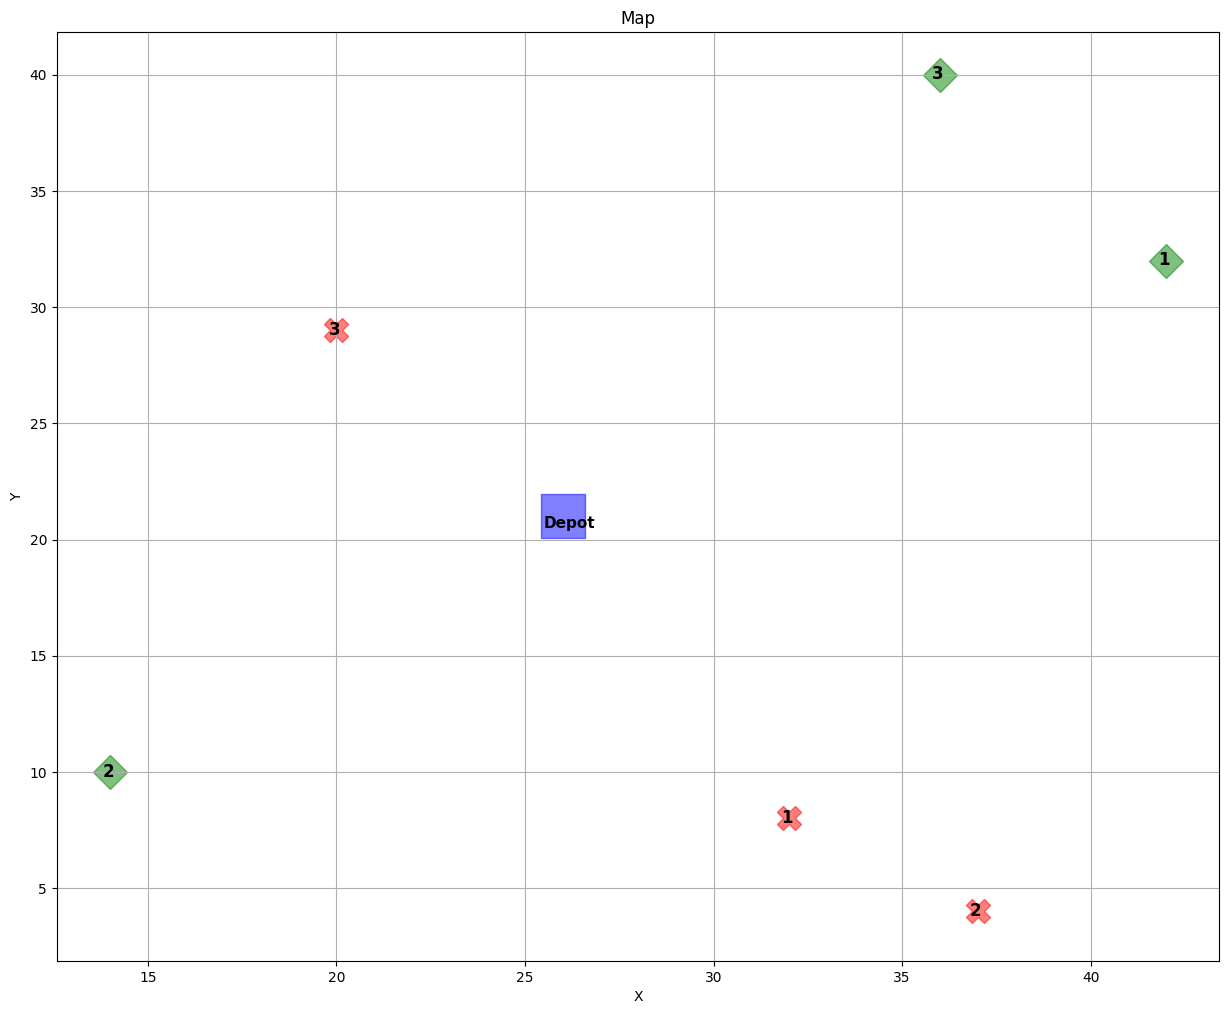

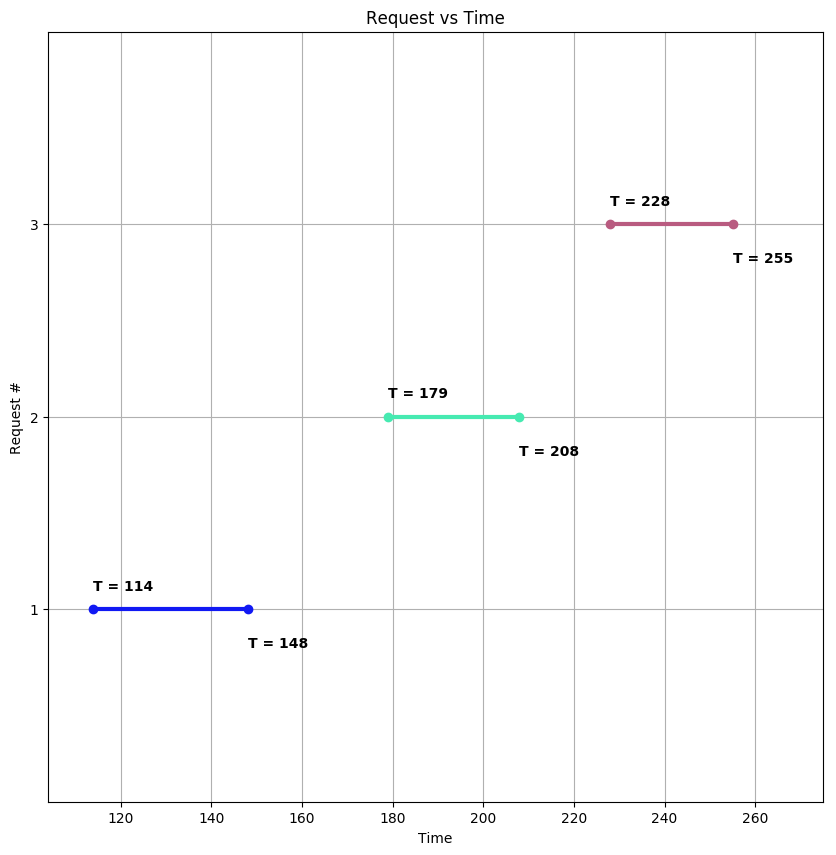


Request((42, 32), 114, (32, 8), 34)
Request((14, 10), 179, (37, 4), 29)
Request((36, 40), 228, (20, 29), 27)

pickup time = Any[114, 179, 228]
pickup location = Any[(42, 32), (14, 10), (36, 40)]
dropoff time = Any[148, 208, 255]
dropoff location = Any[(32, 8), (37, 4), (20, 29)]
duration = Any[34, 29, 27]


In [164]:
# Parameters

# Number of requests
R = 3
# Generate all input data
requests, depot = genGrid(R, 1)

# Get Location coordinates.
nodes = getLocations(depot, requests)

# Compute distance matrix
dist_map = distance_matrix(nodes, length(requests));

# Find max distance from the depot to a pickup and use it as the reference time to start the TimeSlots for requests
maxDistFromDepot = maximum(dist_map[:,1])

# Now, assign random time slots beginning from maxDistFromDepot to all requests.
requests = assign_pickup_time(maxDistFromDepot, requests)

plot_Request_Time_Window(requests)   # Calling this function here coz of modified slots.

p_t = []
p_l = []
d_t = []
d_l = []
duration = []

println("")
for r = 1:R
    println(requests[r])
    
    push!(p_t, requests[r].pickup_time)
    push!(p_l, requests[r].pickup_pos)
    push!(d_t, requests[r].pickup_time + requests[r].duration)
    push!(d_l, requests[r].dropoff_pos)
    push!(duration, requests[r].duration)
end

println("")
println("pickup time = ", p_t)
println("pickup location = ", p_l)
println("dropoff time = ", d_t)
println("dropoff location = ", d_l)
println("duration = ", duration)


In [165]:
K = 2 # Number of cabs
small_m = minimum(p_t) - maximum(d_t) - maximum(dist_map)
println("small_m = ", small_m)
Big_M = sum(dist_map)
println("Big_M = ", Big_M)
epsilon = 1
small_m2 = 0
small_m3 = -1
lambda = 100 # Weighting of the cab number

using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, y[1:K], Bin)                     # if the cab is dispatched or not
@variable(m, x[1:R, 1:K], Bin)                # if the request is assigned to the cab or not
@variable(m, mask[1:2R+1, 1:2R+1, 1:K], Bin)  # Given one cab, if the node p to node d is connected or not

 # Express the total travel distance of each cab
@expression(m, d[k in 1:K], sum(dist_map[p, d] * mask[p, d, k] for p in 1:2R+1, d in 1:2R+1))

# More variables 
@variable(m, more2[1:R, 1:R, 1:K], Bin)
@variable(m, less2[1:R, 1:R, 1:K], Bin)

# Variables to solve issue 1
@variable(m, temp[1:R, 1:R, 1:K], Bin)
@variable(m, temp2[1:R, 1:R, 1:K], Bin)

## Variables to solve issue 2 --- Depot to pickup variables
@variable(m, temp3[1:R, 1:K], Bin)
@variable(m, temp4[1:R, 1:K], Bin)

@expression(m, sum1[r in 1:R, k in 1:K], sum(x[i,k] for i in 1:r))
@expression(m, sum2[r in 1:R, k in 1:K], sum(sum1[i,k] for i in 1:r))

for k = 1:K 
    for r = 1:R
        @constraint(m, sum1[r,k] - 1 <= R*temp3[r,k] - epsilon*(1-temp3[r,k])) # R is the upper bound
        @constraint(m, sum1[r,k] - 1 >= small_m3*(1-temp3[r,k]))

        @constraint(m, sum2[r,k] - 1 >= small_m3*temp4[r,k] + epsilon*(1-temp4[r,k]))
        @constraint(m, sum2[r,k] - 1 <= R*(1-temp4[r,k]))
    end
    
    for r = 1:R
        @constraint(m, mask[1, 2*r, k] - 1 >= small_m3*(1 - temp3[r,k]*temp4[r,k]))
    end
end

## Variables to solve issue 2 --- Dropoff variables to Depot
@variable(m, temp5[1:R, 1:K], Bin)
@variable(m, temp6[1:R, 1:K], Bin)
 
@expression(m, sum3[r in 1:R, k in 1:K], sum(x[i,k] for i in r:R))
@expression(m, sum4[r in 1:R, k in 1:K], sum(sum3[i,k] for i in r:R))

for k = 1:K 
    for r = 1:R
        @constraint(m, sum3[r,k] - 1 <= R*temp5[r,k] - epsilon*(1-temp5[r,k])) # R is the upper bound
        @constraint(m, sum3[r,k] - 1 >= small_m3*(1-temp5[r,k]))

        @constraint(m, sum4[r,k] - 1 >= small_m3*temp6[r,k] + epsilon*(1-temp6[r,k]))
        @constraint(m, sum4[r,k] - 1 <= R*(1-temp6[r,k]))
    end
    
    for r = 1:R
        @constraint(m, mask[2*r+1, 1, k] - 1 >= small_m3*(1 - temp5[r,k]*temp6[r,k]))
    end
end

### Constraints to solve issue 1 
for r1 = 1:R-1
    for r2 = (r1+1):R
        for k = 1:K
            @constraint(m, sum(x[r1:r2,k])-2 <= (R-2)*more2[r1, r2, k]-(1-more2[r1, r2, k]))
            @constraint(m, sum(x[r1:r2,k])-2 >= (-2)*less2[r1, r2, k]+(1-less2[r1, r2, k]))
        end
    end
end


# Must dispatch one cab to each request
@constraint(m, constraint1[r in 1:R], sum(x[r, k] for k =1:K) == 1)

for r = 1:R
    for k = 1:K
        # if x[r, k] == 1 => mask[2r, 2r+1, k] == 1
        @constraint(m, mask[2r, 2r+1, k] - 1 >= small_m3*(1 - x[r, k]))
    end
end


# Constraints for distance travelled by fleet
for k = 1:K
    # if y[k] == 0 => d[k] == 0
    @constraint(m, d[k] <= Big_M * y[k])
    
    # if y[k] == 1 => d[k] > 0
    @constraint(m, d[k] >= small_m2 * (1 - y[k]) + epsilon*y[k])
    
    # Dispatch cabs from the smallest number
    if k < K
        @constraint(m, y[k] >= y[k+1])
    end
end


for r1 = 1:R-1
    for r2 = (r1+1):R
        for k = 1:K
            @constraint(m, p_t[r2] - d_t[r1] - dist_map[2*r2, 2*r1+1] >= small_m*(1 - x[r1, k]*x[r2, k]))
            #@constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1 - (x[r1, k]*x[r2, k])))
            @constraint(m, temp2[r1, r2, k] - 1 >= small_m3*(1 - (x[r1, k]*x[r2, k])))
            @constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1 - temp[r1, r2, k]*temp2[r1, r2, k]))
           
            @constraint(m, temp[r1, r2, k] - 1 >= small_m3*(1-more2[r1, r2, k]*less2[r1, r2, k]))
            #@constraint(m, mask[2*r1+1, 2*r2, k] - 1 >= small_m3*(1-more2[r1, r2, k]*less2[r1, r2, k]))  
        end
    end
end



for p_idx in 1:2R+1
    for d_idx in 1:2R+1
        # At most 1 cab can be assigned to each travel route between 2 nodes
        @constraint(m, sum(mask[p_idx, d_idx, k] for k in 1:K) <= 1)
    end
end

for k = 1:K
    for p_idx in 1:2R+1
        # Given one cab and one starting node, at most one ending node can be assigned
        @constraint(m, sum(mask[p_idx, d_idx, k] for d_idx in 1:2R+1) <= 1)
    end
end

# Minimize: the number of dispatched cabs + the total travel distances by dispatched cabs
@objective(m, Min, sum(lambda*y + d))

@time(status = solve(m))

#println(m)
println(status)
if status != :Optimal
    println("\n", Status,"\nCheck the parameters again...")
else
    println("Optimum = ", getobjectivevalue(m))
    println("y = ", getvalue(y))

    println("x = ")
    for r = 1:R
        println(getvalue(x)[r, 1:K])
    end

    println("mask = ")
    mask_best = getvalue(mask)
    for k = 1:K
        for p_idx in 1:2R+1
            println(mask_best[p_idx, 1:2R+1, k])
        end
        println("")
    end
    println("d = ", getvalue(d))
end

small_m = -193.0
Big_M = 1212.0
Academic license - for non-commercial use only
  0.006746 seconds (559 allocations: 126.094 KiB)
Optimal
Optimum = 418.0
y = [1.0, 1.0]
x = 
[1.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
mask = 
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

d = [138.0, 80.0]


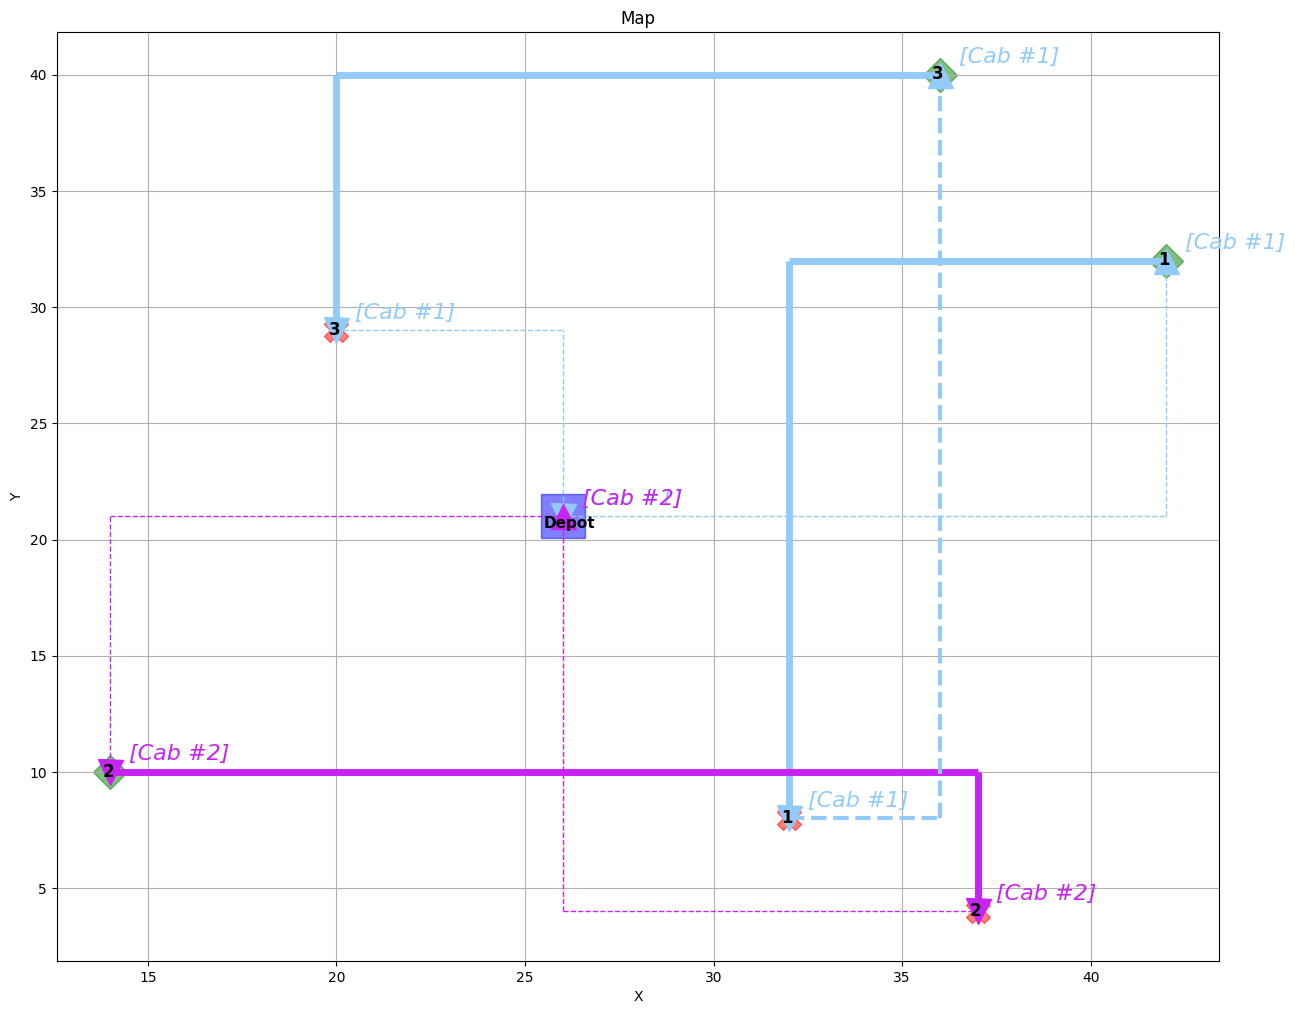

In [168]:
plot_car_route(requests, depot, mask_best)